In [1]:
import pandas as pd 
data_train = pd.read_csv('sarcasm_tam_train.csv')   
data_val = pd.read_csv('sarcasm_tam_dev.csv')   
data_test = pd.read_csv('sarcasm_tam_test.csv') 

In [2]:
text_train = data_train['Text']
text_val = data_val['Text']
text_test = data_test['Text']

class_label_train = data_train['labels']
class_label_val = data_val['labels']
class_label_test = data_test['labels']

In [3]:
class_label_train.value_counts(), class_label_test.value_counts()

(labels
 Non-sarcastic    21740
 Sarcastic         7830
 Name: count, dtype: int64,
 labels
 Non-sarcastic    4621
 Sarcastic        1717
 Name: count, dtype: int64)

In [4]:
from sklearn import preprocessing
import numpy as np
from keras.utils import to_categorical

In [5]:
classes_list = ["Non-sarcastic", "Sarcastic"]
label_index_train = class_label_train.apply(classes_list.index)
label_index_val = class_label_val.apply(classes_list.index)
label_index_test = class_label_test.apply(classes_list.index)

In [6]:
import ktrain
from ktrain import text
import numpy as np

In [7]:
MODEL_NAME = 'distilbert-base-multilingual-cased'
t = text.Transformer(MODEL_NAME, maxlen=30, classes=classes_list)
trn = t.preprocess_train(np.array(text_train), np.array(class_label_train))
val = t.preprocess_test(np.array(text_val), np.array(class_label_val))
model = t.get_classifier()
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=32)

c:\Users\nimmi\anaconda3\Lib\site-packages\ktrain\text\preprocessor.py:382: UserWarning: The class_names argument is replacing the classes argument. Please update your code.
  warnings.warn(


preprocessing train...
language: id
train sequence lengths:
	mean : 10
	95percentile : 23
	99percentile : 43


c:\Users\nimmi\anaconda3\Lib\site-packages\ktrain\utils.py:744: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  warnings.warn(


Is Multi-Label? False
preprocessing test...
language: id
test sequence lengths:
	mean : 10
	95percentile : 21
	99percentile : 41


In [8]:
filepath = "tamil_distilbert_2"

model.load_weights(filepath)

learner.validate(class_names=t.get_classes())

predictor = ktrain.get_predictor(learner.model, preproc=t)

predict = predictor.predict(text_test.values)

198/198 [==============================] - 124s 592ms/step
               precision    recall  f1-score   support

Non-sarcastic       0.84      0.89      0.86      4630
    Sarcastic       0.64      0.53      0.58      1706

     accuracy                           0.79      6336
    macro avg       0.74      0.71      0.72      6336
 weighted avg       0.78      0.79      0.79      6336



In [9]:
predicted_prob = predictor.predict_proba(text_test.values)
label_test = to_categorical(np.asarray(label_index_test))
label_test

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [10]:
from sklearn.metrics import classification_report 
print(classification_report(label_index_test ,predicted_prob.argmax(axis = 1), target_names=predictor.get_classes()))

               precision    recall  f1-score   support

Non-sarcastic       0.84      0.88      0.86      4621
    Sarcastic       0.63      0.53      0.58      1717

     accuracy                           0.79      6338
    macro avg       0.73      0.71      0.72      6338
 weighted avg       0.78      0.79      0.78      6338



In [11]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from scipy import interp

def plot_AUC_ROC(y_true, y_pred):
    n_classes = 2

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
############################################################################################
    lw = 2
    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure()

    plt.plot(fpr["micro"], tpr["micro"],
            label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
            color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
            label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
            color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    #classes_list1 = ["DE","NE","DK"]
    classes_list1 = predictor.get_classes()
    for i, color,c in zip(range(n_classes), colors,classes_list1):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                label='{0} (AUC = {1:0.2f})'
                ''.format(c, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic curve')
    plt.legend(loc="lower right")

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j],fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

[[4089  532]
 [ 805  912]]
Normalized confusion matrix
[[0.8848734 0.1151266]
 [0.468841  0.531159 ]]


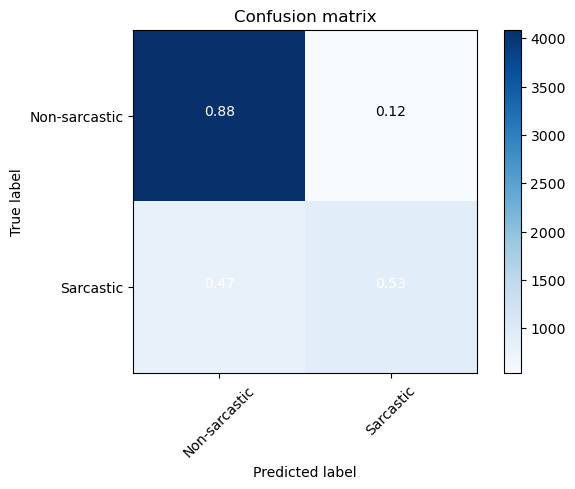

C:\Users\nimmi\AppData\Local\Temp\ipykernel_22212\3340382807.py:31: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


<Figure size 640x480 with 0 Axes>

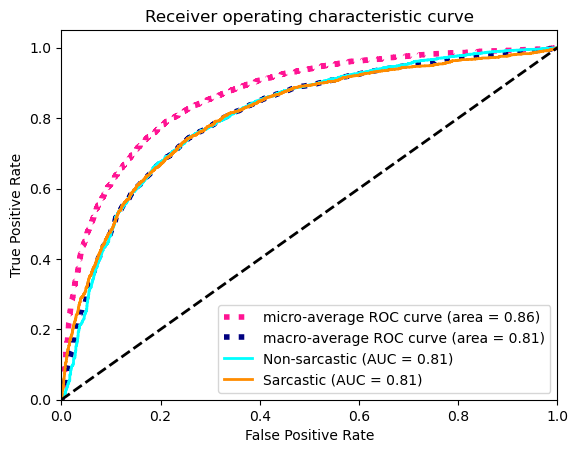

In [13]:
from sklearn import metrics
plt.clf()
cnf_matrix = metrics.confusion_matrix(label_index_test, predicted_prob.argmax(axis = 1))
print(cnf_matrix)
plot_confusion_matrix(cnf_matrix, classes = predictor.get_classes(), normalize = True)
plt.show()
# plt.savefig("confusion.pdf", format = 'pdf', dpi =1000)

plt.clf()
plot_AUC_ROC(label_test, predicted_prob)
plt.savefig("ROC_AUC_distilbert_tamil.pdf", format = 'pdf', dpi =1000)


In [14]:
y_pred = predicted_prob.argmax(axis = 1)

In [15]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
# Calculate precision, recall, F1 score
precision, recall, f1, _ = precision_recall_fscore_support(label_index_test, y_pred, average='weighted')
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Precision: 0.7802660205630089
Recall: 0.7890501735563269
F1 Score: 0.7829670624918794


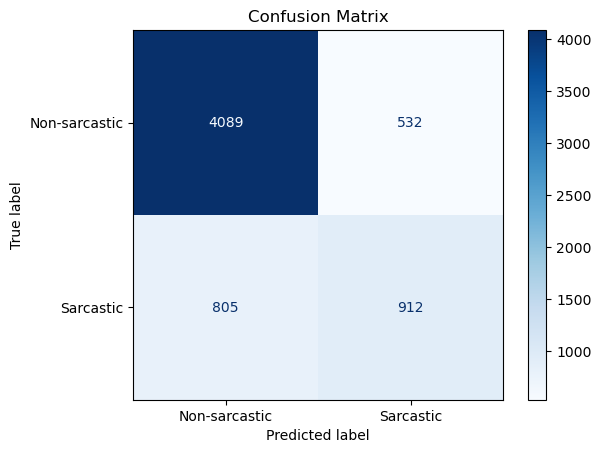

<Figure size 640x480 with 0 Axes>

In [16]:
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(class_label_test, predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes_list)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()
plt.savefig("confusion_distil_tam.pdf", format = 'pdf', dpi =1000)